# XAI(LIME)을 활용하여 MNIST 손글씨를 판별하는 Randomforest 모형 설명하기

#### 코드 출처 : https://github.com/marcotcr/lime/

## 1. 패키지 및 데이터 로드

In [7]:
#패키지 로드
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [8]:
#MNIST 자료 로드
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [9]:
# 255 Scale to 0~1 Scale
X_train = X_train/255
X_test  = X_test/255

Text(0.5, 1.0, 'Digit: 5')

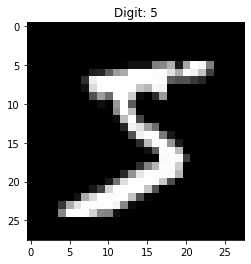

In [10]:
# 이미지 예시 플랏 작성
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_train[0], interpolation = 'none',cmap = plt.cm.gray)
ax1.set_title('Digit: {}'.format(y_train[0]))

## 2. Random Forest 모형 Fitting

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

# 주어진 Input으로 부터 step by step으로 전처리 및 모델 Fitting을 수행 할 수 있도록 Pipeline 구축 

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('RF', RandomForestClassifier())
                              ])

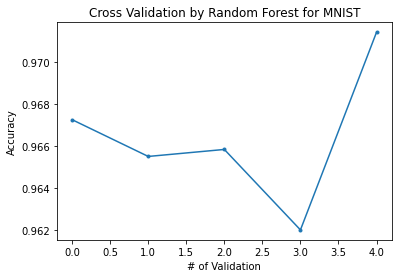

In [12]:
# 랜덤포레스트 모형 Fitting 
simple_rf_pipeline.fit(X_train, y_train)

# 5 Fold cross-validation 수행시 모델의 Performance 확인
scores = cross_val_score(simple_rf_pipeline, X_train, y_train, cv=5)
plt.plot(scores, '.-');
plt.title('Cross Validation by Random Forest for MNIST')
plt.xlabel('# of Validation');
plt.ylabel('Accuracy');

## 3. LIME을 통한 모델 설명

In [13]:
# 모든 모듈을 Reload
%load_ext autoreload
%autoreload 2

# lime load
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [14]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Lime image explainer class 생성
explainer = lime_image.LimeImageExplainer(verbose = False)

# gray scale 이미지를 super pixel 단위로 나누어주는 segmentation algorithm 설정
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [15]:
# test set 자료로 y_hat 생성
pipe_pred_test = simple_rf_pipeline.predict(X_test)

# 정답을 맞춘 test set 이미지중 1개를 추출 
correct_idx = np.random.choice(np.where(pipe_pred_test==y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(correct_idx, y_test[correct_idx], pipe_pred_test[correct_idx])) 

Using #4461 where the label was 5 and the pipeline predicted 5


In [17]:
%%time
#시간 출력 
# 이미지를 설명
explanation = explainer.explain_instance(X_test[correct_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)


Wall time: 8.92 s


In [26]:
# 옵션에 대한 설명을 확인시 아래의 주석을 풀고 실행 
# 설명할 이미지에 대한 y_hat 근사 모델 Fitting 함수
# ?explainer.explain_instance
# 설명된 이미지에 대한 출력을 위한 함수
# ?explanation.get_image_and_mask 

Text(0.5, 1.0, 'Positive/Negative Regions for 5')

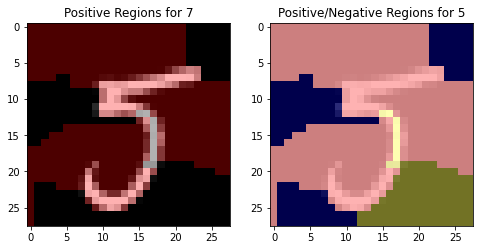

In [19]:
# 정답을 맞춘 이미지에 대하여 어떠한 super pixel에 의하여 정답을 맞추게 되었는지 빨간색으로 표시 (그 밖에 영역은 0:검은색)
temp, mask = explanation.get_image_and_mask(y_test[correct_idx], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))

# negative effect를 가진 super-pixel을 함께 표시하고자 하는경우
temp, mask = explanation.get_image_and_mask(y_test[correct_idx], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[correct_idx]))

## 4. 정분류 원인 탐색 

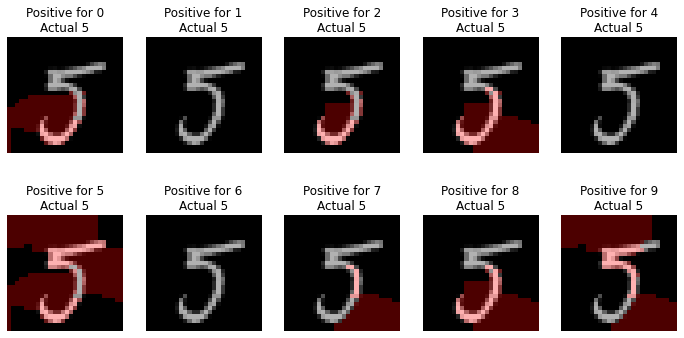

In [20]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[correct_idx], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[correct_idx]))
    c_ax.axis('off')

## 5. 오분류 원인 탐색 

In [21]:
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #9883 where the label was 5 and the pipeline predicted 6


In [22]:
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

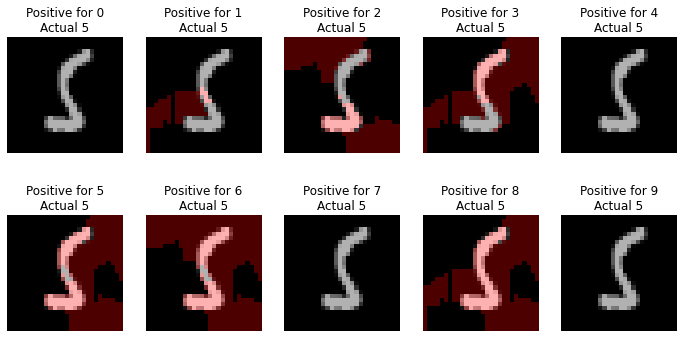

In [23]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')